In [82]:
import numpy as np
import math

#旋转矩阵 角度制！
def rotation_matrix(axis, rotate_angle):
    axis = axis.lower()
    radian = math.radians(rotate_angle)
    if axis == 'x':
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, math.cos(radian), -math.sin(radian)],
                                    [0, math.sin(radian), math.cos(radian)]])
    elif axis == 'y':
        rotation_matrix = np.array([[math.cos(radian), 0, math.sin(radian)],
                                    [0, 1, 0],
                                    [-math.sin(radian), 0, math.cos(radian)]])
    elif axis == 'z':
        rotation_matrix = np.array([[math.cos(radian), -math.sin(radian), 0],
                                    [math.sin(radian), math.cos(radian), 0],
                                    [0, 0, 1]])
    else:
        raise ValueError("Invalid axis, please choose from 'x', 'y', or 'z'")
    
    return rotation_matrix


In [83]:
#这里修改一些常量
#修改角度和极化角psi. 极化角实际上用不到
theta = math.pi/3
phi = math.pi/6
psi = 0 #math.pi/8

#以及sample time
t = np.arange(0., 5.0 , 0.01)  #/y  时间坐标，注意间隔需要满足Nyquist 定理

#日地距离 和光速 和探测器角速度
d = 1.496 *10**11 #m
c = 3. * 10**8  *24*3600*365  #m/y 
w = 2*math.pi

#定义 h_+ h_x的参量
A1 = 10. 
f1 = 5.           #Hz/y
phi1 = 0          #phase

A2 = 8. 
f2 = 5.           #Hz/y 
phi2 = math.pi/4  #phase

In [84]:
# F  这个是按照ppt上张量运算得到的，但是人为地加了一个负号
def F(theta,phi,t):
    #探测器角速度w
    w = 2 * math.pi   #/rad/y
    # 定义向量和张量
    # 探测器参考系，三角平面为xOz
    n1 = np.array([-1/2, 0,np.sqrt(3)/2])
    n2 = np.array([1, 0, 0])
    n3 = np.array([-1/2, 0, -np.sqrt(3)/2])
    Z = np.array([0, 0, 1])


    #接下来考虑60度偏角，X轴不变
    R = rotation_matrix('x', 60) #角度制!
    n1_ = np.dot(R,n1)
    n2_ = np.dot(R,n2)
    n3_ = np.dot(R,n3)

    #接下来考虑wt度偏角，z轴不变 初始状态是探测器xyz和太阳xyz对齐
    
    R = rotation_matrix('z', w * t *180/np.pi)
    n1_ = np.dot(R,n1_)
    n2_ = np.dot(R,n2_)
    n3_ = np.dot(R,n3_)
    # theta 和phi 是太阳坐标系下的源的方位角
    x =np.sin(theta) * np.cos(phi)
    y =np.sin(theta) * np.sin(phi)
    z =np.cos(theta)
    nhat = np.array([x,y,z])

    xhat = np.cross(Z, nhat)
    norm = np.linalg.norm(xhat)
    xhat = xhat/norm

    yhat = np.cross(xhat, nhat)



    # 计算张量积
    n11 = np.outer(n1_, n1_)
    n22 = np.outer(n2_, n2_)
    n33 = np.outer(n3_, n3_)

    xx = np.outer(xhat, xhat)
    yy = np.outer(yhat, yhat)

    xy = np.outer(xhat, yhat)
    yx = np.outer(yhat, xhat)
    # 计算差和和
    eplus = xx - yy
    ecross = xy + yx

    # 计算 Dect
    Dect = (n11 + n22 - 2*n33) / (2*np.sqrt(3))

    # 计算 Fplus 和 Fcross
    Fplus = -np.tensordot(Dect, eplus, axes=([0, 1], [0, 1]))
    Fcross = -np.tensordot(Dect, ecross, axes=([0, 1], [0, 1]))
    return Fplus, Fcross

In [85]:
F_plus, F_cross = F(theta,phi,0.1)

print(F_plus, F_cross)

0.2563119341168199 -0.22950656224457405


In [86]:
def h_sin(A, f, phi_0, t):

    return A * np.sin(2.0 * np.pi * f * t + phi_0)

In [87]:

###############################################
#生成信号
j = 0
strain = np.ones(len(t))
for i in t: 
    h_cross = h_sin(A1, f1, phi1 , i)
    h_plus = h_sin(A2,f2, phi2 , i)
    F_plus, F_cross = F(theta,phi,i)
    strain[j] = F_cross*h_cross + F_plus*h_plus
    j+= 1
    
    

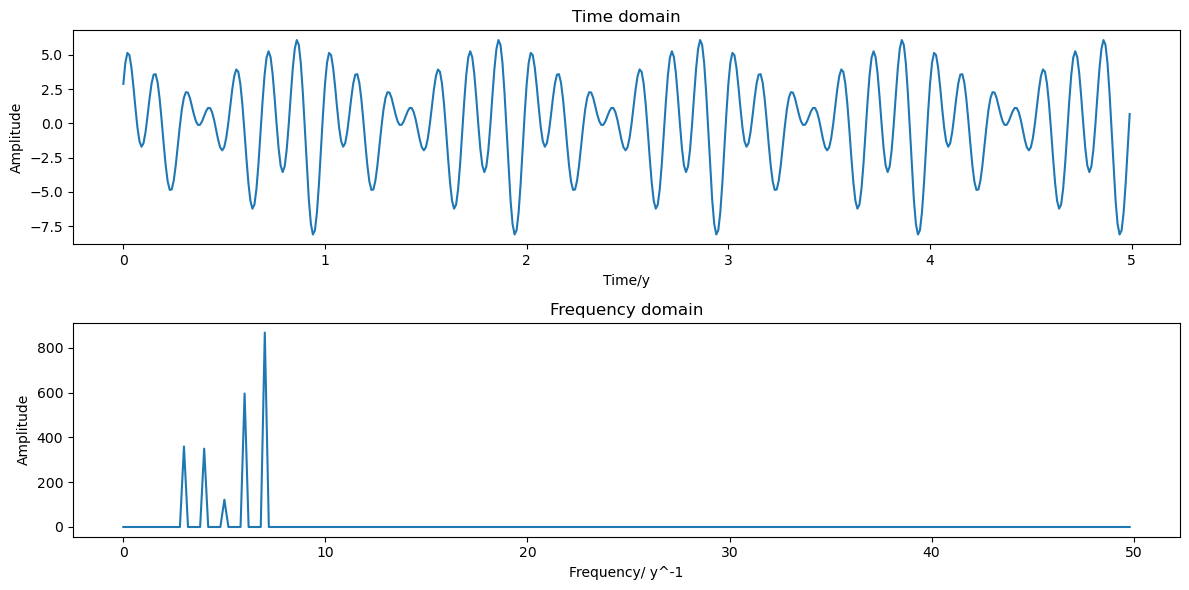

In [88]:
#FFT 变换
import matplotlib.pyplot as plt

## 对信号进行傅里叶变换
fft_signal = np.fft.fft(strain)
# 获取频率向量
frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))

# 只取正频率部分
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft_signal = fft_signal[:len(fft_signal)//2]

# 绘制时域信号
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, strain)
plt.title('Time domain')
plt.xlabel('Time/y')
plt.ylabel('Amplitude')

# 绘制频域信号
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, np.abs(positive_fft_signal))
plt.title('Frequency domain')
plt.xlabel('Frequency/ y^-1')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [89]:
#大概是因为F随时间改变，所以FFT得到的频率不是h的频率，而是有所偏差

In [90]:
#接下来考虑多普勒效应 h(t)-> h(t-nx/c)

In [91]:
x =np.sin(theta) * np.cos(phi)
y =np.sin(theta) * np.sin(phi)
z =np.cos(theta)
nhat = np.array([x,y,z])



In [92]:



j = 0
strain_d = np.ones(len(t))
for i in t: 
    #初始状态是探测器xyz和太阳xyz对齐,所以有个初始相位
    phi_d = w * i + 270/180*math.pi  #探测器角度相位
    ndhat = np.array([d * np.cos(phi_d),d * np.sin(phi_d), 0 ])
    delay = np.dot(nhat,ndhat)/c
    h_cross = h_sin(A1, f1, phi1 , i-delay)
    h_plus = h_sin(A2,f2, phi2 , i-delay)
    F_plus, F_cross = F(theta,phi,i)
    
    strain_d[j] = F_cross*h_cross + F_plus*h_plus
    j+= 1
    
    

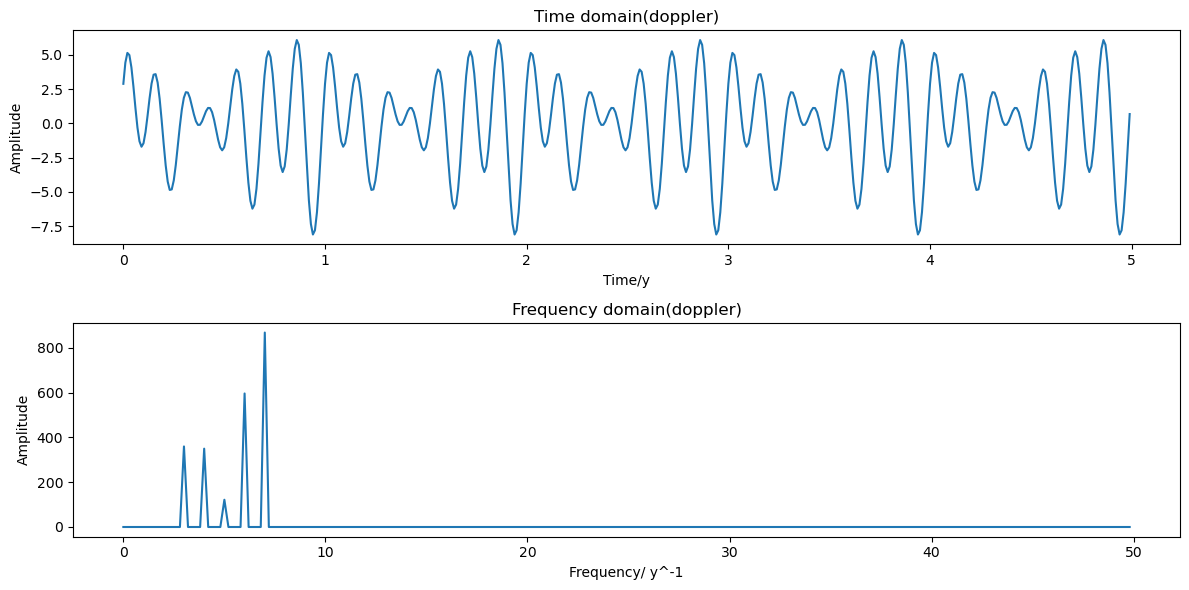

In [94]:
#FFT 变换
import matplotlib.pyplot as plt

## 对信号进行傅里叶变换
fft_signal = np.fft.fft(strain_d)
# 获取频率向量
frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))

# 只取正频率部分
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft_signal = fft_signal[:len(fft_signal)//2]

# 绘制时域信号
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, strain_d)
plt.title('Time domain(doppler)')
plt.xlabel('Time/y')
plt.ylabel('Amplitude')

# 绘制频域信号
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, np.abs(positive_fft_signal))
plt.title('Frequency domain(doppler)')
plt.xlabel('Frequency/ y^-1')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()